# Herschel Stripe 82 master catalogue
## Preparation of Hyper Suprime-Cam Subaru Strategic Program Catalogues (HSC-SSP) data

This catalogue comes from `dmu0_HSC`.

In the catalogue, we keep:

- The `object_id` as unique object identifier;
- The position;
- The g, r, i, z, y, N816, N921 aperture magnitude (for now in 3”);
- The g, r, i, z, y, N816, N921 kron fluxes and magnitudes.

**TODO**: Check that the aperture magnitudes are aperture corrected and that all the magnitudes are AB.

**TODO**: Check for stellarity.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "hsc_ra"
DEC_COL = "hsc_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "object_id": "hsc_id",
        "ra": "hsc_ra",
        "dec": "hsc_dec",
        "gmag_aperture30": "m_ap_suprime_g",
        "gmag_aperture30_err": "merr_ap_suprime_g",
        "gmag_kron": "m_suprime_g",
        "gmag_kron_err": "merr_suprime_g",
        "rmag_aperture30": "m_ap_suprime_r",
        "rmag_aperture30_err": "merr_ap_suprime_r",
        "rmag_kron": "m_suprime_r",
        "rmag_kron_err": "merr_suprime_r",
        "imag_aperture30": "m_ap_suprime_i",
        "imag_aperture30_err": "merr_ap_suprime_i",
        "imag_kron": "m_suprime_i",
        "imag_kron_err": "merr_suprime_i",
        "zmag_aperture30": "m_ap_suprime_z",
        "zmag_aperture30_err": "merr_ap_suprime_z",
        "zmag_kron": "m_suprime_z",
        "zmag_kron_err": "merr_suprime_z",
        "ymag_aperture30": "m_ap_suprime_y",
        "ymag_aperture30_err": "merr_ap_suprime_y",
        "ymag_kron": "m_suprime_y",
        "ymag_kron_err": "merr_suprime_y",
        "n816mag_aperture30": "m_ap_suprime_n816",
        "n816mag_aperture30_err": "merr_ap_suprime_n816",
        "n816mag_kron": "m_suprime_n816",
        "n816mag_kron_err": "merr_suprime_n816",
        "n921mag_aperture30": "m_ap_suprime_n921",
        "n921mag_aperture30_err": "merr_ap_suprime_n921",
        "n921mag_kron": "m_suprime_n921",
        "n921mag_kron_err": "merr_suprime_n921",
    })


catalogue = Table.read("../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_Herschel-Stripe-82.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [6]:
catalogue[:10].show_in_notebook()

idx,hsc_id,hsc_ra,hsc_dec,m_ap_suprime_g,merr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_y,merr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_n816,merr_ap_suprime_n816,m_suprime_n816,merr_suprime_n816,m_ap_suprime_n921,merr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,f_ap_suprime_g,ferr_ap_suprime_g,f_suprime_g,ferr_suprime_g,flag_suprime_g,f_ap_suprime_r,ferr_ap_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_ap_suprime_i,ferr_ap_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_ap_suprime_z,ferr_ap_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_ap_suprime_y,ferr_ap_suprime_y,f_suprime_y,ferr_suprime_y,flag_suprime_y,f_ap_suprime_n816,ferr_ap_suprime_n816,f_suprime_n816,ferr_suprime_n816,flag_suprime_n816,f_ap_suprime_n921,ferr_ap_suprime_n921,f_suprime_n921,ferr_suprime_n921,flag_suprime_n921
0,41628227487137807,353.800155119,-0.254015009613,23.5513,0.0499457,23.5232,0.0511875,23.2438,0.0512789,23.2264,0.0527751,22.3906,0.0343772,22.3119,0.0355681,22.1051,0.0638646,21.9506,0.0624001,22.0117,0.081104,21.9299,0.0836067,26.3164,0.634619,26.2549,0.617031,25.963,0.372757,25.9015,0.362426,1.37867,0.0634213,1.41488,0.0667054,False,1.83018,0.0864386,1.85969,0.0903953,False,4.01586,0.127153,4.31742,0.141436,False,5.22361,0.30726,6.02214,0.346108,False,5.69252,0.425229,6.1384,0.472685,False,0.108001,0.063127,0.114301,0.0649579,False,0.149548,0.0513431,0.158272,0.0528322,False
1,41628227487137808,353.796255469,-0.254058030685,24.988,0.182752,24.5456,0.390949,24.2672,0.131943,nan,nan,24.0631,0.159362,23.9289,0.47776,23.8471,0.317006,nan,nan,24.1111,0.552561,nan,nan,26.3164,0.634357,23.8647,0.20743,25.9631,0.372603,23.5113,0.121838,0.367109,0.0617921,0.55175,0.198673,False,0.713046,0.086652,nan,nan,False,0.860499,0.126302,0.973713,0.428466,False,1.04993,0.306552,nan,nan,False,0.823292,0.418996,nan,nan,False,0.108,0.0631008,1.03304,0.197362,False,0.149548,0.0513217,1.43044,0.16052,False
2,41628227487137813,353.796983869,-0.253008135937,25.5019,0.293753,26.2083,0.21664,26.4335,0.955469,26.6739,0.447617,25.3158,0.501047,25.2671,0.190033,24.788,0.748043,25.7232,0.713992,nan,nan,27.578,5.07627,26.3164,0.634804,28.4591,1.66279,25.963,0.372866,28.1057,0.976677,0.228682,0.0618713,0.119316,0.0238074,False,0.0969621,0.0853285,0.077704,0.032035,False,0.271442,0.125265,0.283908,0.0496915,False,0.441378,0.304097,0.186514,0.122653,False,nan,nan,0.0337904,0.157984,False,0.108001,0.0631455,0.0150094,0.0229868,False,0.149548,0.0513582,0.0207835,0.0186959,False
3,41628227487137819,353.796956871,-0.249420882952,25.6209,0.324817,25.8122,0.208037,23.7371,0.0802788,24.0091,0.0556656,22.51,0.0382235,22.4469,0.0203589,21.5745,0.0284674,21.6894,0.0186995,21.3511,0.0434701,21.4814,0.0288216,26.3164,0.634596,27.6969,1.18565,25.963,0.372744,27.3435,0.696414,0.204942,0.0613121,0.171844,0.0329269,False,1.16187,0.0859078,0.904372,0.0463671,False,3.59748,0.12665,3.81261,0.0714911,False,8.51545,0.223271,7.6603,0.131932,False,10.4603,0.418803,9.27778,0.246285,False,0.108001,0.0631248,0.0302849,0.0330717,False,0.149548,0.0513413,0.0419354,0.0268982,False
4,41628227487137822,353.80343758,-0.248176307289,24.1293,0.0842099,24.1995,0.0573897,23.9441,0.097233,24.1435,0.0739546,23.3359,0.0813137,23.2859,0.0536454,23.3062,0.193951,23.1416,0.111539,22.7727,0.163011,22.6581,0.0995495,26.3164,0.634425,27.3442,1.01123,25.963,0.372643,26.9909,0.593966,0.809642,0.062796,0.758942,0.0401161,False,0.960171,0.085988,0.799132,0.0544326,False,1.68126,0.125914,1.7606,0.0869898,False,1.7279,0.308665,2.01083,0.206576,False,2.82425,0.424029,3.13882,0.287793,False,0.108,0.0631076,0.0419084,0.0390325,False,0.149548,0.0513274,0.0580304,0.0317463,False
5,41628227487137823,353.8044029,-0.247967757558,25.2474,0.233457,nan,nan,24.6269,0.183373,nan,nan,25.4539,0.575755,nan,nan,26.6365,4.

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = [
        'merr_ap_suprime_i', 'merr_ap_suprime_r', 'merr_ap_suprime_z',
        'merr_ap_suprime_y', 'merr_ap_suprime_g']
FLAG_NAME = 'hsc_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 157216 sources.
The cleaned catalogue has 157208 sources (8 removed).
The cleaned catalogue has 8 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

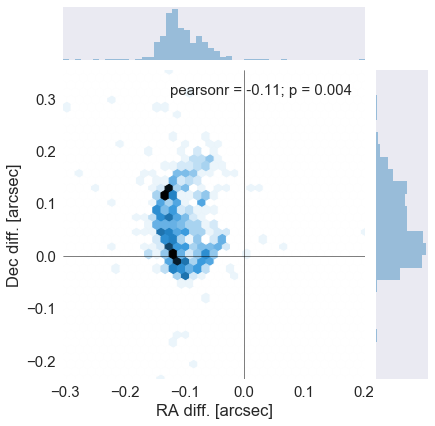

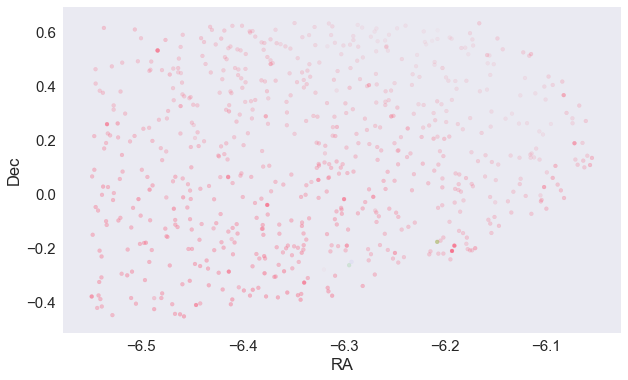

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.11123353978064188 arcsec
Dec correction: -0.04582559505321715 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

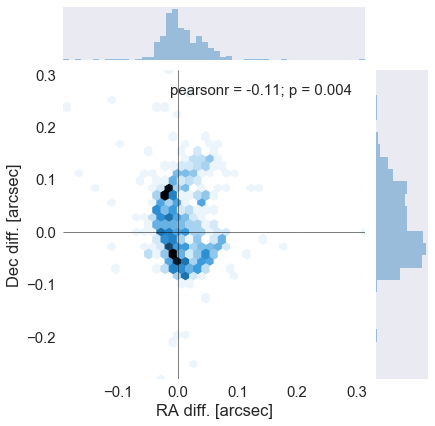

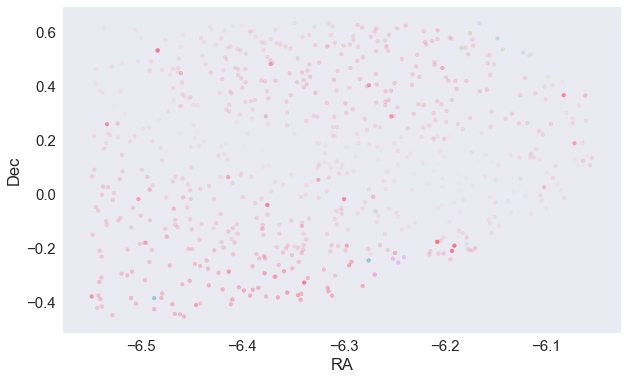

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "hsc_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

701 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/HSC-SSP.fits".format(OUT_DIR), overwrite=True)